In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
np.random.seed(0)
tf.set_random_seed(1234)

In [3]:
def inference(x, n_in=None, n_time=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)

    # 時系列データの形式をAPIの仕様に合わせるため、最終的に
    # (ミニバッチサイズ, 入力次元数) が時間長分ある形に変形
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_in])
    x = tf.split(x, n_time, 0)

    cell_forward = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    cell_backward = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

    outputs, _, _ = \
        rnn.static_bidirectional_rnn(cell_forward, cell_backward, x,
                                     dtype=tf.float32)

    W = weight_variable([n_hidden * 2, n_out])
    b = bias_variable([n_out])
    y = tf.nn.softmax(tf.matmul(outputs[-1], W) + b)

    return y


def loss(y, t):
    cross_entropy = \
        tf.reduce_mean(-tf.reduce_sum(
                       t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)),
                       reduction_indices=[1]))
    return cross_entropy


def training(loss):
    optimizer = \
        tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step


def accuracy(y, t):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [4]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

now loading...
loaded
now training...
LLLLL
epoch: 0  validation loss: 1.38903  validation accuracy: 0.5495
LLLLL
epoch: 1  validation loss: 1.26558  validation accuracy: 0.58225
LLLLL
epoch: 2  validation loss: 0.788498  validation accuracy: 0.74525
LLLLL
epoch: 3  validation loss: 0.818152  validation accuracy: 0.74375
LLLLL
epoch: 4  validation loss: 0.956571  validation accuracy: 0.70225
LLLLL
epoch: 5  validation loss: 0.407708  validation accuracy: 0.86725
LLLLL
epoch: 6  validation loss: 0.378204  validation accuracy: 0.87325
LLLLL
epoch: 7  validation loss: 0.312203  validation accuracy: 0.90325
LLLLL
epoch: 8  validation loss: 0.383711  validation accuracy: 0.8795
LLLLL
epoch: 9  validation loss: 0.663791  validation accuracy: 0.78375
AAAAAA


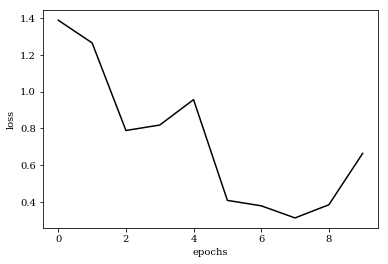

accuracy:  0.7796


In [5]:
if __name__ == '__main__':
    
    '''
    データの生成
    '''
    print("now loading...")
    mnist = datasets.fetch_mldata('MNIST original', data_home='.')
    
    print("loaded")
    
    n = len(mnist.data)
    N = 30000  # MNISTの一部を使う
    N_train = 20000
    N_validation = 4000
    indices = np.random.permutation(range(n))[:N]  # ランダムにN枚を選択

    X = mnist.data[indices]
    X = X / 255.0
    X = X - X.mean(axis=1).reshape(len(X), 1)
    X = X.reshape(len(X), 28, 28)  # 時系列データに変換
    y = mnist.target[indices]
    Y = np.eye(10)[y.astype(int)]  # 1-of-K 表現に変換

    X_train, X_test, Y_train, Y_test = \
        train_test_split(X, Y, train_size=N_train)

    X_train, X_validation, Y_train, Y_validation = \
        train_test_split(X_train, Y_train, test_size=N_validation)
        
        
    '''
    モデル設定
    '''
    n_in = 28
    n_time = 28
    n_hidden = 128
    n_out = 10

    x = tf.placeholder(tf.float32, shape=[None, n_time, n_in])
    t = tf.placeholder(tf.float32, shape=[None, n_out])

    y = inference(x, n_in=n_in, n_time=n_time, n_hidden=n_hidden, n_out=n_out)
    loss = loss(y, t)
    train_step = training(loss)

    accuracy = accuracy(y, t)

    early_stopping = EarlyStopping(patience=10, verbose=1)
    history = {
        'val_loss': [],
        'val_acc': []
    }
    
    '''
    モデル学習
    '''
    epochs = 10
    batch_size = 250

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    n_batches = N_train // batch_size
    
    print("now training...")

    for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        print("LLLLL")
        
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end]
            })

        val_loss = loss.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation
        })
        val_acc = accuracy.eval(session=sess, feed_dict={
            x: X_validation,
            t: Y_validation
        })

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print('epoch:', epoch,
              ' validation loss:', val_loss,
              ' validation accuracy:', val_acc)

        if early_stopping.validate(val_loss):
            break

    print("AAAAAA")
    '''
    学習の進み具合を可視化
    '''
    loss = history['val_loss']

    plt.rc('font', family='serif')
    fig = plt.figure()
    plt.plot(range(len(loss)), loss,
             label='loss', color='black')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    '''
    予測精度の評価
    '''
    accuracy_rate = accuracy.eval(session=sess, feed_dict={
        x: X_test,
        t: Y_test
    })
    print('accuracy: ', accuracy_rate)
